## Data Cleaning & Preprocessing 

This notebook prepares the raw dataset for modeling by executing all critical data cleaning steps in a reproducible and statistically secure way.

1. **Missing Value Handling**

A completeness check revealed that some variables (especially in earlier years) contained missing values. Rows with missing targets (revenuegrowth_t+1) were dropped to ensure a clean supervised learning setup. For other variables:

- Numeric features were imputed using the mean, calculated from the training set only;
- The same imputer was applied to the test set, ensuring no data leakage.

2. **Categorical Encoding**

The main categorical variable, label (which encodes sector groupings such as “Enterprise SaaS” or “Mega‑Cap Tech”), was:
- Converted to a categorical data type;
- One-hot encoded using pd.get_dummies(), separately for train and test sets.

This ensures compatibility with machine learning algorithms that expect numerical inputs while preserving sector-level interpretability.

3. **Train/Test Split**

To prevent bias and ensure model generalizability, the data was split into training and test sets with stratification on the label column. This ensures proportional representation of sectors across both sets, reflecting realistic economic diversity.

4. **Saving the Preprocessed Data**

The resulting df_companies_train.pkl and df_companies_test.pkl files contain:
- Cleaned, imputed, and encoded features;
- A ready-to-use structure for downstream model training and validation.

This pipeline ensures a robust, statistically defensible foundation for all ML models used later in the revenue growth forecasting process.

In [47]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from typing import List
import requests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [48]:
df_companies = pd.read_csv("Step5_all_companies_features_with_labels_cleaned_macro_flag.csv")

In [49]:
df_companies.head()

,Date,revenue,netincome,r&d,sg&a,ebit,revenuegrowth,ebitmargin,netmargin,rd_to_revenue,...,ticker,label,macro_year,GDPC1,CPIAUCSL,FEDFUNDS,UNRATE,GS10,UMCSENT,negative_equity_flag
0,2019-01-27,11716000000,4141000000,2376000000,991000000,3804000000,0.206094,0.324684,0.353448,0.202800,...,NVDA,Mega‑Cap Tech,2018,20304.874,251.0995,1.831667,3.891667,2.91,98.366667,False
1,2019-01-31,177722000,-53885000,58841000,140116000,-55084000,0.597458,-0.309945,-0.303198,0.331085,...,SMAR,Collab & CX SaaS,2018,20304.874,251.0995,1.831667,3.891667,2.91,98.366667,False
2,2019-01-31,249824000,-140077000,84551000,214899000,-136864000,1.103746,-0.547842,-0.560703,0.338442,...,CRWD,Cloud & Data,2018,20304.874,251.0995,1.831667,3.891667,2.91,98.366667,False
3,2019-01-31,267016000,-99011000,89854000,201359000,-97765000,0.728046,-0.366139,-0.370805,0.336512,...,MDB,Cloud & Data,2018,20304.874,251.0995,1.831667,3.891667,2.91,98.366667,False
4,2019-01-31,2822180000,-418258000,1211832000,1238682000,-463284000,0.316899,-0.164158,-0.148204,0.429396,...,WDAY,Enterprise SaaS,2018,20304.874,251.0995,1.831667,3.891667,2.91,98.366667,False


In [50]:
# We will check for missisng values
print("Does the dataset have any missing values?")
has_missing = df_companies.isnull().values.any()
print(f"Result: {has_missing}")

print("\nSummary of missing values per column:")
missing_summary = df_companies.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

Does the dataset have any missing values?
Result: True

Summary of missing values per column:
sales_to_capital    18
revenuegrowth       14
dtype: int64


In [51]:
# We can check the data structure
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   494 non-null    object 
 1   revenue                494 non-null    int64  
 2   netincome              494 non-null    int64  
 3   r&d                    494 non-null    int64  
 4   sg&a                   494 non-null    int64  
 5   ebit                   494 non-null    int64  
 6   revenuegrowth          480 non-null    float64
 7   ebitmargin             494 non-null    float64
 8   netmargin              494 non-null    float64
 9   rd_to_revenue          494 non-null    float64
 10  sga_to_revenue         494 non-null    float64
 11  operatingcashflow      494 non-null    int64  
 12  capex                  494 non-null    int64  
 13  assets                 494 non-null    int64  
 14  equity                 494 non-null    int64  
 15  totald

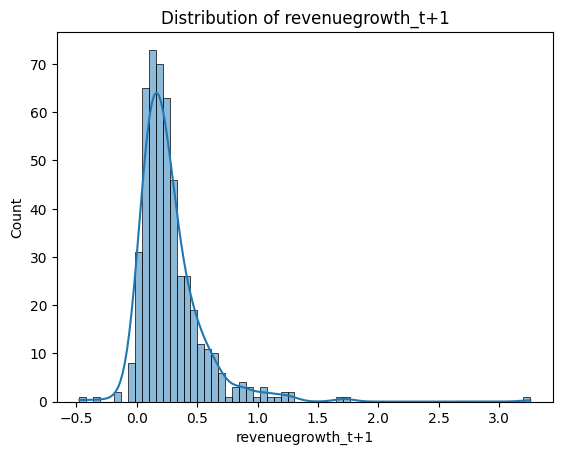

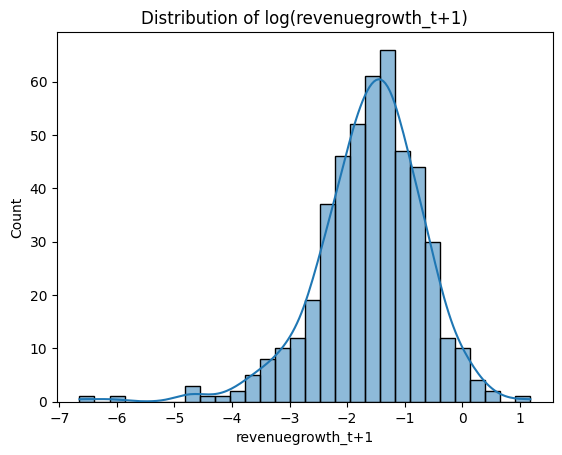

In [52]:
# visualize the target distribution (also checking how would look like log transformation).
# Since I am using regrowth_t+1 as a key DCF input, I shall make sure that if I conduct the log transformation 
# it doesn’t introduce interpretability issues when I later want to simulate or invert the output 
# (e.g., I'll need to np.exp(pred) after model prediction to get back to actual growth rates).

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_companies['revenuegrowth_t+1'], kde=True)
plt.title("Distribution of revenuegrowth_t+1")
plt.show()

# Check log-transformed version (only for > 0 values)
sns.histplot(np.log(df_companies['revenuegrowth_t+1'][df_companies['revenuegrowth_t+1'] > 0]), kde=True)
plt.title("Distribution of log(revenuegrowth_t+1)")
plt.show()


In [53]:
# How many target values is equal or below 0 
(df_companies['revenuegrowth_t+1'] <= 0).sum()

19

In [54]:
# Check skewness and kurtosis of the target variable
from scipy.stats import skew, kurtosis

# Drop NaNs
target = df_companies['revenuegrowth_t+1'].dropna()

# Filter out only positive values for log-transform (log is undefined for ≤ 0)
target_pos = target[target > 0]
log_target = np.log(target_pos)

# Compute statistics
skew_original = skew(target)
kurt_original = kurtosis(target)  # Excess kurtosis (normal dist = 0)

skew_log = skew(log_target)
kurt_log = kurtosis(log_target)

# Display results
print("Original revenuegrowth_t+1:")
print(f"  Skewness: {skew_original:.2f}")
print(f"  Kurtosis (excess): {kurt_original:.2f}")

print("\nLog-transformed revenuegrowth_t+1:")
print(f"  Skewness: {skew_log:.2f}")
print(f"  Kurtosis (excess): {kurt_log:.2f}")

Original revenuegrowth_t+1:
  Skewness: 3.70
  Kurtosis (excess): 28.02

Log-transformed revenuegrowth_t+1:
  Skewness: -0.96
  Kurtosis (excess): 3.21


Interpretation:

1. Original revenuegrowth_t+1:
   - Highly right-skewed (long tail of large growth values);
   - Extremely heavy-tailed — many outliers (kurtosis > 28 indicates frequent extreme values);
2. Log-transformed:
   - Much more symmetrical (mild left-skew now).
   - Kurtosis reduced significantly to ~3.2 — close to normal distribution (excess kurtosis of 0).

Conclusion:
- Applying a log transformation to revenuegrowth_t+1 will:
  - Normalize the distribution;
  - Reduce extreme outliers;
  - Should improve the stability and accuracy of your regression models, especially linear ones.
Steps (if I choose to do it later):
- Apply the transformation only to positive values,
- Use np.exp() to revert predictions during inference.

WHat if my data contain a lot of zero or negative growth values?

- we can use log1p or log(x + c) with a constant shift;
- I have to remember to invert carefully during prediction.

Wartości odstające (IQR):
Number of outliers: 30
2      0.927009
5      1.738791
8      0.883891
16     0.857575
18    -0.473684
23     0.710234
80     1.285133
82     1.063325
85     0.856255
88     1.084887
89     1.002324
92     1.236274
97     0.873466
99     0.816399
108    3.258145
109    0.807622
113    0.777649
135    0.912514
139    0.704792
145    0.924837
183   -0.313413
193    1.059504
199    0.714031
202    1.200815
213    1.694307
273    0.826239
280    0.694098
294    1.061431
370    1.258545
463    1.142034
Name: revenuegrowth_t+1, dtype: float64


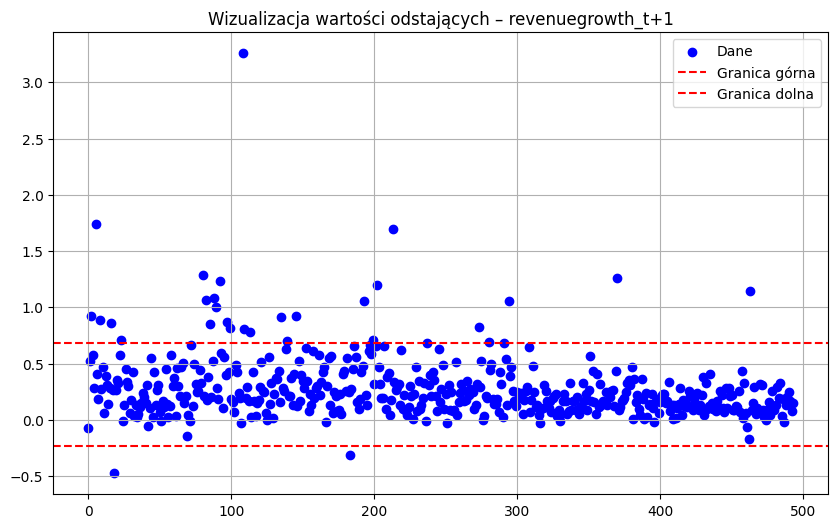

In [55]:
# How many outliers does our target variable have?

# Select the target variable
target = 'revenuegrowth_t+1'
dane = df_companies[target].dropna()  # drop NA to avoid errors

# IQR method
Q1 = np.percentile(dane, 25)
Q3 = np.percentile(dane, 75)
IQR = Q3 - Q1

# Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers_iqr = dane[(dane < lower_bound) | (dane > upper_bound)]

print("Wartości odstające (IQR):")
print("Number of outliers:", len(outliers_iqr))
print(outliers_iqr)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(range(len(dane)), dane, color='blue', label='Dane')
plt.axhline(y=upper_bound, color='red', linestyle='--', label='Granica górna')
plt.axhline(y=lower_bound, color='red', linestyle='--', label='Granica dolna')

plt.title("Wizualizacja wartości odstających – revenuegrowth_t+1")
plt.legend()
plt.grid(True)
plt.show()


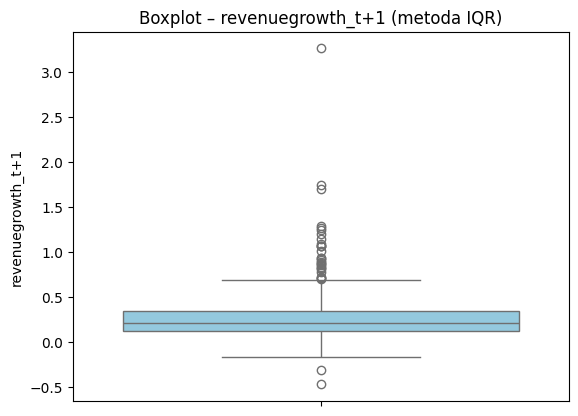

In [56]:
# Boxplot
sns.boxplot(y=dane, color="skyblue")
plt.title("Boxplot – revenuegrowth_t+1 (metoda IQR)")
plt.show()

In [57]:
# sort df_companies values by revenue growth to observe outlier
sorted_df_companies = df_companies.copy()
# Sort descending by next‑year revenue growth
sorted_df_companies = df_companies[["revenue", "revenuegrowth", "revenuegrowth_t+1", "ticker"]].sort_values('revenuegrowth', ascending=False).reset_index(drop=True)

# Show the top 50 rows (you can scroll or download as CSV from the UI)
print("Companies sorted by revenuegrowth(Top 10)", sorted_df_companies.head())

# we can see that duolingo is a huge outlier. Keep it for now, and we will see how does our model will behave based on such extreme input.

Companies sorted by revenuegrowth(Top 10)       revenue  revenuegrowth  revenuegrowth_t+1 ticker
0    70760000    1386.450980           1.285133   DUOL
1  2651368000       3.258145           0.546320     ZM
2   264748000       1.738791           1.236274   SNOW
3   641959000       1.694307           0.648809   BILL
4   161696000       1.285133           0.550886   DUOL


In [58]:
# Start of the cleaning data process
# Drop unneeded columns 
drop_columns = ['ticker', 'Date', 'macro_year']

# Drop only those columns that exist in the current DataFrame
df_companies = df_companies.drop(columns=[col for col in drop_columns if col in df_companies.columns])

In [59]:
# transforming all catregrical variables to category, instead the object
df_companies["label"] = df_companies["label"].astype('category')

In [60]:
# frequency table for "labels" 

print(df_companies['label'].value_counts(dropna = False))
print()
print(df_companies['label'].value_counts(dropna = False, normalize = True))
print()

label
Cloud & Data        121
Enterprise SaaS      92
Vertical SaaS        92
Collab & CX SaaS     59
AI‑DevOps            52
Consumer SaaS        31
Mega‑Cap Tech        26
Mature Pivots        21
Name: count, dtype: int64

label
Cloud & Data        0.244939
Enterprise SaaS     0.186235
Vertical SaaS       0.186235
Collab & CX SaaS    0.119433
AI‑DevOps           0.105263
Consumer SaaS       0.062753
Mega‑Cap Tech       0.052632
Mature Pivots       0.042510
Name: proportion, dtype: float64



How to impute missing values?

In ordser to avoid data leakage we should fit our imputers and scalers only on the training data, not on the test set:
- Phase 1: fit() on training data:
  - Learns the mean, median, scaling parameters, categories, etc.
- Phase 2: transform() on training and test:
  - Applies the same transformation — but test data never affects what's learned.

What will go wrong if we fit() on the full dataset?
- the test set would "leak" into model preparation;
- we will be using information from the future to impute the past;
- validation scores would look too optimistic;
- this leads to overfitting and invalid performance estimation

In [61]:
# Now we shall conduct the train-test split
# we should stratify on label column to:
# obtain similar sector representation in both training and test sets;
# avoid sector-based bias leakage;
# support the insight that sector membership is important for learning revenuegrowth_t+1 patterns

# Step 1: Drop rows with missing target
df_companies = df_companies[df_companies['revenuegrowth_t+1'].notna()]

strata = df_companies['label']  # Categorical sector label; Each sector is represented proportionally in train/test;

# Step 2: Train/test split on full DataFrame, stratifying on label
df_companies_train, df_companies_test = train_test_split(
    df_companies, test_size=0.2, stratify=strata, random_state=42
)

print(f"Liczebność zbioru treningowego:: {len(df_companies_train)}")
print(f"Liczebność zbioru testowego:: {len(df_companies_test)}")

# Later (after imputation we will do: 
# X_train = df_train.drop(columns=['revenuegrowth_t+1', 'Date', 'ticker', 'macro_year'])
# y_train = df_train['revenuegrowth_t+1']
# X_test = df_test.drop(columns=['revenuegrowth_t+1', 'Date', 'ticker', 'macro_year'])
# y_test = df_test['revenuegrowth_t+1']

In [62]:
# Imputation 

In [63]:
# Select numeric columns to impute
numeric_cols = df_companies.select_dtypes(include='number').columns.tolist()

# Split the dataset first (e.g. using train_test_split)
# Here we assume df_train and df_test are already created
# and 'df_companies' is just a placeholder for either of them.

# STEP 1: Define the imputer with the desired strategy
imputer_mean = SimpleImputer(strategy='mean')

# STEP 2: Fit the imputer ONLY on training data — this calculates the means
df_companies_train[numeric_cols] = imputer_mean.fit_transform(df_companies_train[numeric_cols])

# STEP 3: Apply the same transformation to the test data — using training-set statistics
df_companies_test[numeric_cols] = imputer_mean.transform(df_companies_test[numeric_cols])

# This ensures:
# - The model learns imputation logic ONLY from training data
# - No information leaks from test set into training


In [64]:
# check the missing data after imputation

# checking data after imputation
df_companies_train.info()
df_companies_test.info()


<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 349 to 379
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   revenue                395 non-null    float64 
 1   netincome              395 non-null    float64 
 2   r&d                    395 non-null    float64 
 3   sg&a                   395 non-null    float64 
 4   ebit                   395 non-null    float64 
 5   revenuegrowth          395 non-null    float64 
 6   ebitmargin             395 non-null    float64 
 7   netmargin              395 non-null    float64 
 8   rd_to_revenue          395 non-null    float64 
 9   sga_to_revenue         395 non-null    float64 
 10  operatingcashflow      395 non-null    float64 
 11  capex                  395 non-null    float64 
 12  assets                 395 non-null    float64 
 13  equity                 395 non-null    float64 
 14  totaldebt              395 non-null    float6

In [65]:
# Let's save the datasets (after imputation) to pickle files (*.pkl)

df_companies_train.to_pickle("outputs/df_companies_train.pkl") 
df_companies_test.to_pickle("outputs/df_companies_test.pkl") 

In [66]:
# Coding categorical variables

In [67]:
# STEP 1: Select your nominal columns
nominal_columns = ['label']

# STEP 2: Initialize encoder

# Train dataset

df_companies_train_encoded = pd.get_dummies(df_companies_train,
                                     columns = nominal_columns,
                                     drop_first = True, # pomijamy pierwszy poziom
                                     dtype = int) # domyślnie bool

# Test dataset

df_companies_test_encoded = pd.get_dummies(df_companies_test,
                                    columns = nominal_columns,
                                    drop_first = True,
                                    dtype = int)

df_companies_train_encoded.head()

,revenue,netincome,r&d,sg&a,ebit,revenuegrowth,ebitmargin,netmargin,rd_to_revenue,sga_to_revenue,...,GS10,UMCSENT,negative_equity_flag,label_Cloud & Data,label_Collab & CX SaaS,label_Consumer SaaS,label_Enterprise SaaS,label_Mature Pivots,label_Mega‑Cap Tech,label_Vertical SaaS
349,1.317845e+09,-345582000.0,2.943490e+08,7.425230e+08,-8.766200e+07,0.087642,-0.066519,-0.262233,0.223356,0.563437,...,2.951667,58.975000,False,0,0,0,0,0,0,0
185,1.453047e+09,-243267000.0,2.715220e+08,9.913220e+08,-1.738550e+08,0.491879,-0.119649,-0.167419,0.186864,0.682237,...,0.894167,81.541667,False,0,0,0,1,0,0,0
466,2.806489e+09,-836097000.0,1.287949e+09,1.714755e+09,-1.094773e+09,0.358641,-0.390086,-0.297916,0.458918,0.610997,...,3.957500,65.350000,False,1,0,0,0,0,0,0
273,1.745500e+10,-496000000.0,2.054000e+09,7.105000e+09,-3.834000e+09,0.567017,-0.219651,-0.028416,0.117674,0.407047,...,1.442500,77.616667,False,0,0,1,0,0,0,0
446,6.204450e+08,2702000.0,1.513640e+08,2.010540e+08,9.630000e+05,0.314828,0.001552,0.004355,0.243960,0.324048,...,3.957500,65.350000,False,0,0,0,0,0,0,1


In [68]:
# Checking after encoding that the train and test sets have the same columns
assert list(df_companies_train_encoded.columns) == list(df_companies_test_encoded.columns), "Column mismatch between train and test!"

In [69]:
df_companies_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 349 to 379
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   revenue                 395 non-null    float64
 1   netincome               395 non-null    float64
 2   r&d                     395 non-null    float64
 3   sg&a                    395 non-null    float64
 4   ebit                    395 non-null    float64
 5   revenuegrowth           395 non-null    float64
 6   ebitmargin              395 non-null    float64
 7   netmargin               395 non-null    float64
 8   rd_to_revenue           395 non-null    float64
 9   sga_to_revenue          395 non-null    float64
 10  operatingcashflow       395 non-null    float64
 11  capex                   395 non-null    float64
 12  assets                  395 non-null    float64
 13  equity                  395 non-null    float64
 14  totaldebt               395 non-null    float

In [70]:
# Ok, so we have prepered dataset which is ready for ML pipeline.

# Save both encoded DataFrames into a single pickle file
# 'wb' means "write binary"
with open("outputs/df_companies_train_test_encoded.pkl", "wb") as f:
    pickle.dump(df_companies_train_encoded, f)
    pickle.dump(df_companies_test_encoded, f)

# Now both encoded DataFrames are saved together and ready for modeling

In [71]:
# Let's make some features logarithmic to obtain better prediction in the feature
# Retry loading the original train/test data
import pickle

with open("outputs/df_companies_train_test_encoded.pkl", "rb") as f:
    df_train = pickle.load(f)
    df_test = pickle.load(f)

In [72]:
# Define the log transform function
def signed_log(x):
    return np.sign(x) * np.log1p(np.abs(x))

# Features to log-transform
log_features = [
    'revenue', 'netincome', 'r&d', 'sg&a', 'ebit',
    'operatingcashflow', 'capex', 'assets', 'equity', 'totaldebt',
    'cash', 'liabilities', 'netdebt', 'investedcapital',
    'freecashflow', 'nopat'
]

# Add _log columns, then drop original columns
for feature in log_features:
    df_train[f"{feature}_log"] = signed_log(df_train[feature])
    df_test[f"{feature}_log"] = signed_log(df_test[feature])
    # df_train.drop(columns=feature, inplace=True)
    # df_test.drop(columns=feature, inplace=True)

In [73]:
# Display transformed DataFrame
df_train.columns

Index(['revenue', 'netincome', 'r&d', 'sg&a', 'ebit', 'revenuegrowth',
       'ebitmargin', 'netmargin', 'rd_to_revenue', 'sga_to_revenue',
       'operatingcashflow', 'capex', 'assets', 'equity', 'totaldebt', 'cash',
       'liabilities', 'netdebt', 'investedcapital', 'freecashflow',
       'capex_to_revenue', 'roa', 'roe', 'liabilities_to_equity',
       'debt_to_equity', 'nopat', 'roic', 'sales_to_capital',
       'fcf_to_netincome', 'revenuegrowth_t+1', 'GDPC1', 'CPIAUCSL',
       'FEDFUNDS', 'UNRATE', 'GS10', 'UMCSENT', 'negative_equity_flag',
       'label_Cloud & Data', 'label_Collab & CX SaaS', 'label_Consumer SaaS',
       'label_Enterprise SaaS', 'label_Mature Pivots', 'label_Mega‑Cap Tech',
       'label_Vertical SaaS', 'revenue_log', 'netincome_log', 'r&d_log',
       'sg&a_log', 'ebit_log', 'operatingcashflow_log', 'capex_log',
       'assets_log', 'equity_log', 'totaldebt_log', 'cash_log',
       'liabilities_log', 'netdebt_log', 'investedcapital_log',
       'freecashflo

We used np.sign(x) * np.log1p(np.abs(x))

This trick allows us to apply the logarithm to negative numbers, which is normally not allowed (logarithm is undefined for negative values).

- np.abs(x) makes the number positive (so log can be applied),
- np.log1p(...) computes log(1 + x) to safely handle small values (including zero),
- np.sign(x) reattaches the original sign.

Example:

x = -100
signed_log = np.sign(x) * np.log1p(np.abs(x) --> -log(1 + 100) = -4.6

This preserves the magnitude in log scale and retains the negative sign, which helps models understand directionality (loss vs. profit)

5

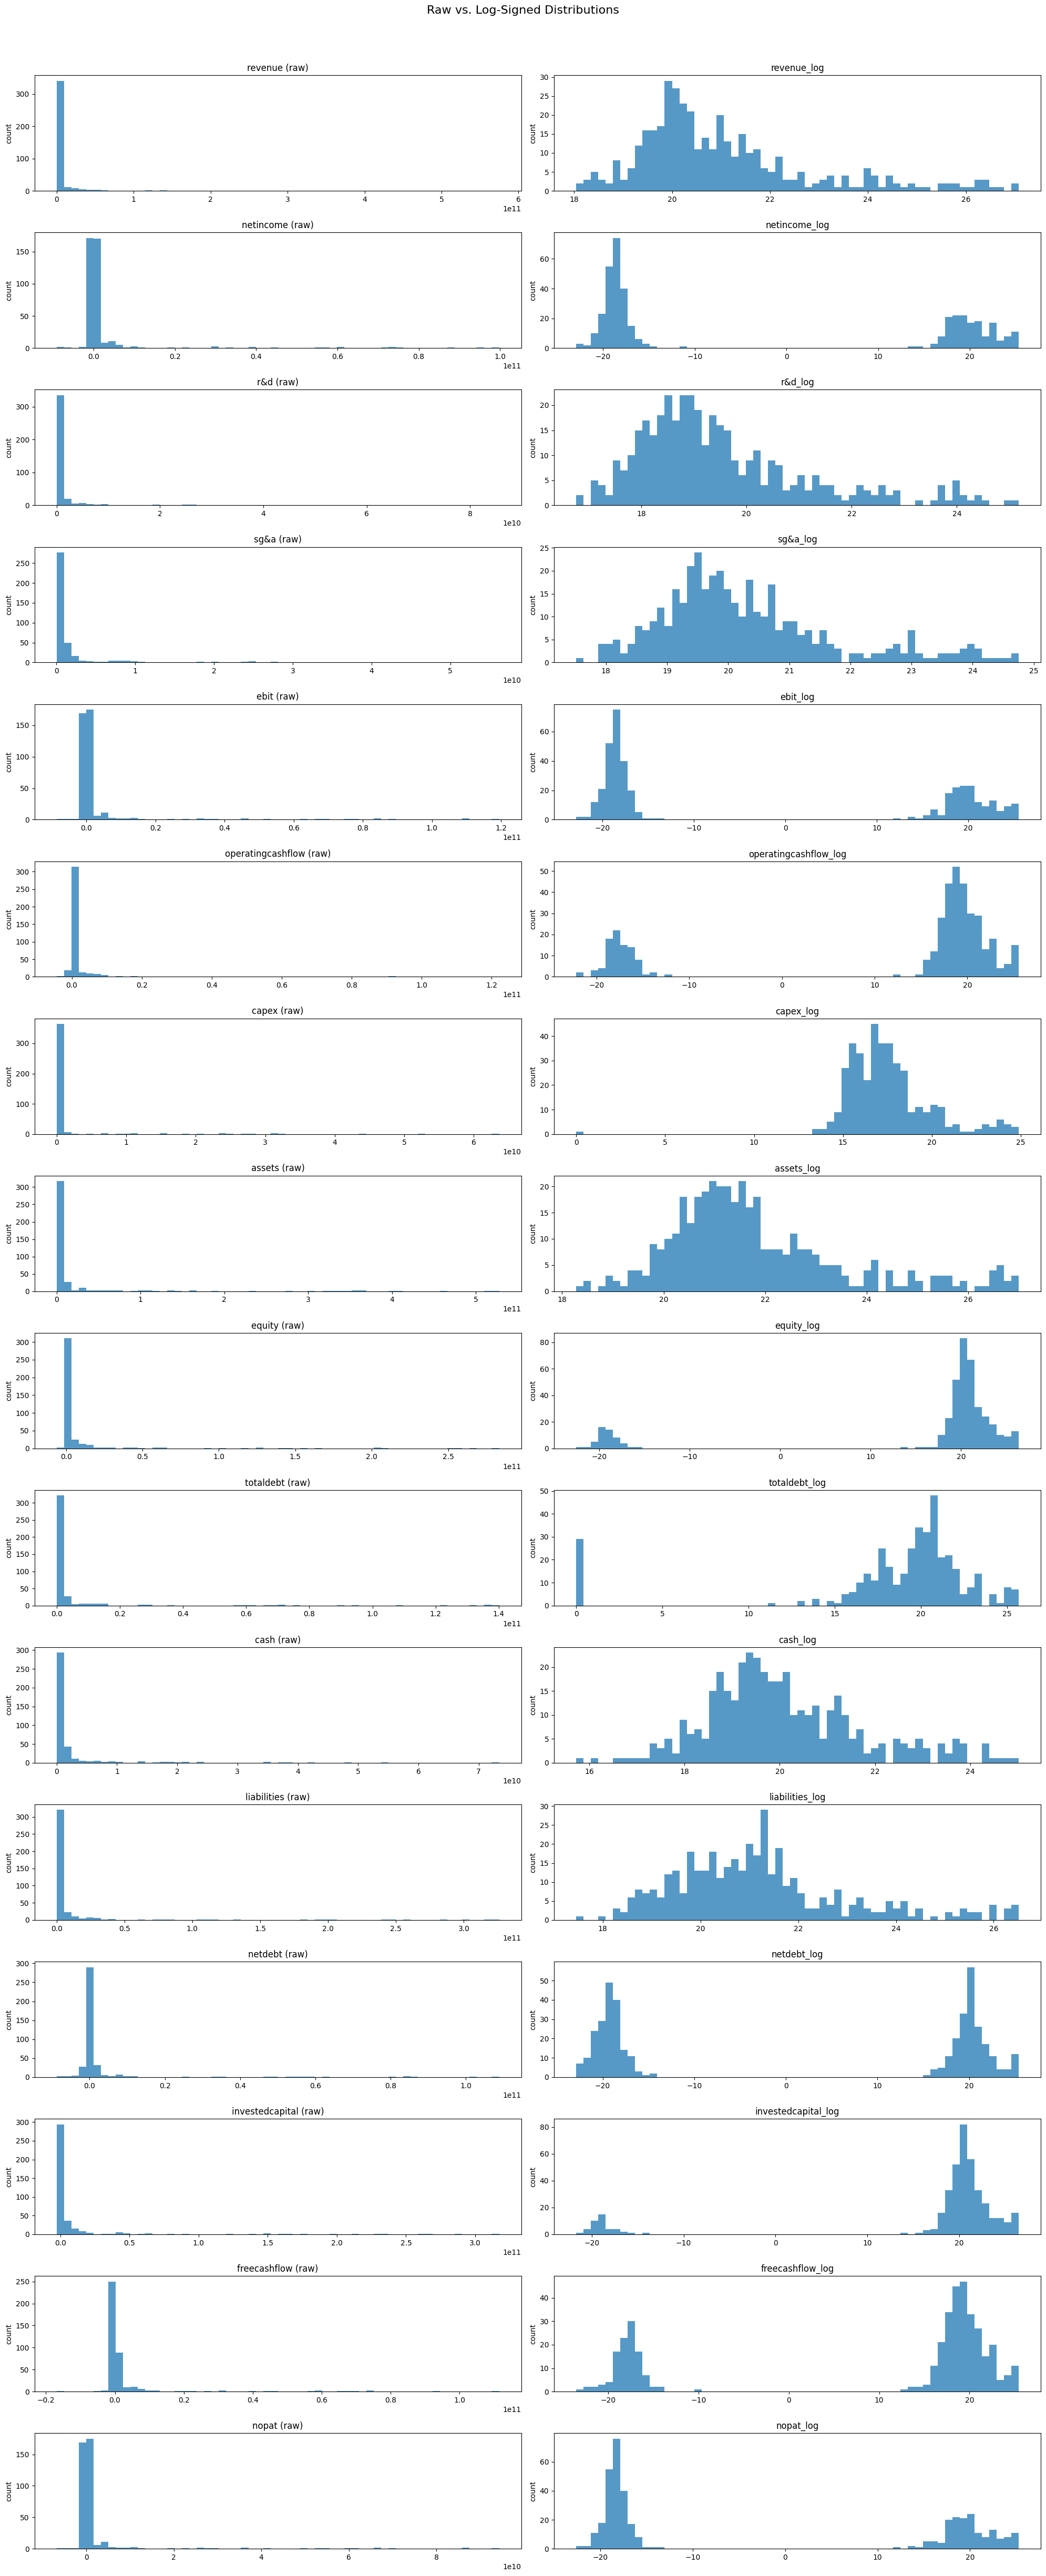

In [74]:
import matplotlib.pyplot as plt

# Diagnostic plotting helper
def plot_raw_vs_log(
    df: pd.DataFrame,
    cols,
    bins: int = 60,
    figsize: tuple = (10, 3),
    show_raw: bool = True,
    show_log: bool = True,
):
    """
    Side-by-side histograms of raw vs. signed-log features.

    Parameters
    ----------
    df : pandas.DataFrame
    cols : list[str]
        Base feature names *without* the '_log' suffix.
    bins : int
    figsize : (w, h) in inches per row
    show_raw, show_log : bool
        Toggle either half of the plot.
    """
    assert show_raw or show_log, "Nothing to plot!"

    n_rows = len(cols)
    n_cols = int(show_raw) + int(show_log)
    fig, axes = plt.subplots(
        n_rows, n_cols,
        figsize=(figsize[0] * n_cols, figsize[1] * n_rows),
        squeeze=False,
        sharey=False          # don’t force identical y-scales
    )

    for r, base in enumerate(cols):
        c = 0
        if show_raw:
            df[base].dropna().plot.hist(
                bins=bins, ax=axes[r, c], alpha=0.75
            )
            axes[r, c].set_title(f"{base} (raw)")
            axes[r, c].set_ylabel("count")
            c += 1

        if show_log:
            log_col = f"{base}_log"
            if log_col in df.columns:
                df[log_col].dropna().plot.hist(
                    bins=bins, ax=axes[r, c], alpha=0.75
                )
                axes[r, c].set_title(log_col)
                axes[r, c].set_ylabel("count")
            else:
                axes[r, c].axis("off")

    for ax in axes.flatten():
        ax.set_xlabel("")
    plt.tight_layout()
    plt.suptitle("Raw vs. Log-Signed Distributions", y=1.02, fontsize=16)
    plt.show()


# Choose the features to inspect & plot
features_to_check = [
    'revenue', 'netincome', 'r&d', 'sg&a', 'ebit',
    'operatingcashflow', 'capex', 'assets', 'equity', 'totaldebt',
    'cash', 'liabilities', 'netdebt', 'investedcapital',
    'freecashflow', 'nopat'      # ≤6-8 keeps the grid readable
]

plot_raw_vs_log(df_train, features_to_check)

In [75]:
# Save transformed DataFrames to a new file
with open("outputs/df_companies_train_test_encoded_logonly.pkl", "wb") as f:
    pickle.dump(df_train, f)
    pickle.dump(df_test, f)

In [76]:
# the log variables gave worse results than original ones.